<a href="https://www.kaggle.com/mohaliy2016/digit-classification?scriptVersionId=88732538" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification of digits using simple CNN and GPU accelerator 

## Dictionary that contains some important variables


In [1]:
cfg = dict(
    batch_size        =  16,
     
    
    LR_START          = 0.000005,
    LR_MAX            = 0.000020,
    LR_MIN            = 0.000001,
    LR_RAMPUP_EPOCHS  =  5,
    LR_SUSTAIN_EPOCHS =  0,
    LR_EXP_DECAY      =  0.8,
    epochs            =  50,

    optimizer         = 'Adam',
    label_smooth_fac  = 0.05
)

## Libraries  ...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os
import tensorflow as tf

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Conv2D , MaxPooling2D , Dense, Flatten, Dropout, Input
from tqdm.keras import TqdmCallback

from tqdm import tqdm
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
sns.set(style='white', context='notebook', palette='deep')

from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


## Load data ...

In [3]:
topDir = '/kaggle' 
os.chdir(topDir)
train = pd.read_csv(os.path.join(topDir, 'input/digit-recognizer/train.csv'))
test = pd.read_csv(os.path.join(topDir, 'input/digit-recognizer/test.csv'))
submission_path = os.path.join(topDir, 'working/submission.csv')
y_train = train['label']
x_train = train.drop(labels = ["label"],axis = 1)
del train

## Distribution plot ...

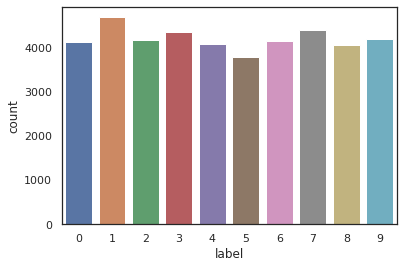

In [4]:
g = sns.countplot(y_train)

## Data preprocessing 

In [5]:
# Normalizing
x_train = x_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

# Spliting the data into training and validation sets
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=random_seed)

## Accelerator initialization ...

In [6]:
DEVICE = "GPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS:  1


## Function monitors and changes the learning rate ...

In [7]:
def getLearnRateCallback(cfg):
    LR_START = cfg["LR_START"]
    LR_MAX = cfg["LR_MAX"] * strategy.num_replicas_in_sync
    LR_MIN = cfg["LR_MIN"]
    LR_RAMPUP_EPOCHS = cfg["LR_RAMPUP_EPOCHS"]
    LR_SUSTAIN_EPOCHS = cfg["LR_SUSTAIN_EPOCHS"]
    LR_EXP_DECAY = cfg["LR_EXP_DECAY"]
   
    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Sequential model 

In [8]:
with strategy.scope():
    visible = Input(shape=(28,28,1))
    conv1 = Conv2D(16, kernel_size=(3,3), activation='relu',strides=(1,1))(visible)
    conv2 = Conv2D(16, kernel_size=(3,3), activation='relu',strides=(1,1))(conv1)
    bat1 = BatchNormalization()(conv2)
    zero1 = ZeroPadding2D(padding=(1,1))(bat1)

    conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding = 'valid', kernel_regularizer=regularizers.l2(0.02))(zero1)
    conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding = 'valid', kernel_regularizer=regularizers.l2(0.02))(conv3)
    bat2 = BatchNormalization()(conv4)


    conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1,1), padding = 'valid')(bat2)
    conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1,1), padding = 'valid')(conv5)
    bat3 = BatchNormalization()(conv6)
    pool1 = MaxPooling2D(pool_size=(2,2))(bat3)
    zero2 = ZeroPadding2D(padding=(1,1))(pool1)

    conv7 = Conv2D(128, kernel_size=(1,1), activation='relu', padding = 'valid', kernel_regularizer=regularizers.l2(0.05))(pool1)
    conv8 = Conv2D(128, kernel_size=(1,1), activation='relu', padding = 'valid', strides=(1,1))(conv7)
    bat4 = BatchNormalization()(conv8)

    flat = Flatten()(bat4)
    hidden1 = Dense(1024, activation='relu')(flat)
    drop1 = Dropout(0.5)(hidden1)

    hidden2 = Dense(512, activation='relu')(drop1)
    drop2 = Dropout(0.5)(hidden2)

    output = Dense(10,activation = 'softmax')(drop2)

    model = Model(inputs=visible, outputs = output)
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 16)        64        
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        9248  

## Model compilation ...

In [9]:
with strategy.scope():    
    model.compile(
        optimizer = cfg["optimizer"],
        loss = [tf.keras.losses.CategoricalCrossentropy(label_smoothing = cfg["label_smooth_fac"])],
        metrics=[tf.keras.metrics.AUC(name='auc')]           
    )

## Model training ... 

In [10]:
callbacks = [getLearnRateCallback(cfg)]
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=cfg['batch_size'],
                    epochs=cfg['epochs'],
                    validation_data=(x_val,y_val), 
                    verbose = 1,
                    shuffle=True,
                    callbacks = callbacks)

Epoch 1/50
2100/2100 [==============================] - 233s 111ms/step - loss: 6.8335 - auc: 0.8915 - val_loss: 5.7926 - val_auc: 0.9946 - lr: 5.0000e-06
Epoch 2/50
2100/2100 [==============================] - 236s 113ms/step - loss: 5.7815 - auc: 0.9861 - val_loss: 5.3386 - val_auc: 0.9983 - lr: 8.0000e-06
Epoch 3/50
2100/2100 [==============================] - 235s 112ms/step - loss: 5.1324 - auc: 0.9957 - val_loss: 4.6882 - val_auc: 0.9992 - lr: 1.1000e-05
Epoch 4/50
2100/2100 [==============================] - 235s 112ms/step - loss: 4.3423 - auc: 0.9984 - val_loss: 3.8538 - val_auc: 0.9994 - lr: 1.4000e-05
Epoch 5/50
2100/2100 [==============================] - 236s 113ms/step - loss: 3.4591 - auc: 0.9992 - val_loss: 2.9802 - val_auc: 0.9996 - lr: 1.7000e-05
Epoch 6/50
2100/2100 [==============================] - 238s 113ms/step - loss: 2.6284 - auc: 0.9995 - val_loss: 2.2264 - val_auc: 0.9997 - lr: 2.0000e-05
Epoch 7/50
2100/2100 [==============================] - 239s 114ms/ste

## Training progress plot ... 

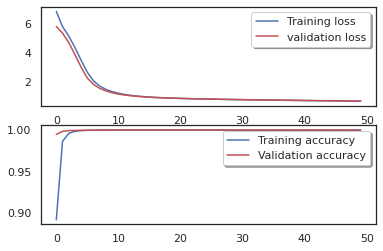

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['auc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_auc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix … evaluation of the model on the validation set 

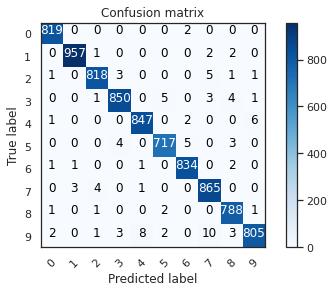

In [12]:
#Function ...
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Prediction and generation of submission file ...


In [13]:
# predict results
results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(submission_path,index=False)

# Upvote the Kernel 